## Download repo


In [0]:
import os
import shutil
import zipfile
import urllib.request

In [0]:
REPO_ZIP_FILE = 'LinearizedNNs-master.zip'
urllib.request.urlretrieve('https://github.com/maxkvant/LinearizedNNs/archive/master.zip', REPO_ZIP_FILE)

REPO_PATH = "LinearizedNNs-master"
if os.path.exists(REPO_PATH):
    shutil.rmtree(REPO_PATH)
    
with zipfile.ZipFile(REPO_ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall('.')
    
assert os.path.exists(REPO_PATH)

## Imports

In [0]:
import sys
sys.path.append(f"{REPO_PATH}/src")

In [4]:
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from xgboost import XGBClassifier

from pytorch_impl.estimators import SgdEstimator
from pytorch_impl.nns import warm_up_batch_norm
from pytorch_impl import ClassifierTraining
from pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from pytorch_impl.nns.utils import to_one_hot
from from_neural_kernels import to_zca, CustomTensorDataset

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def Conv(in_filters, out_filters):
    conv = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1, bias=False)
    conv.weight.data *= np.sqrt(3)
    return conv  

def BatchNorm(num_filters):
    return nn.BatchNorm2d(num_filters)   

class Myrtle10(nn.Module):
    def __init__(self, num_classes=10, input_filters=3, num_filters=256):
        super(Myrtle10, self).__init__()

        self.layers = nn.Sequential(
            Conv(input_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),

            Conv(num_filters, num_filters),   BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters),   BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            Conv(num_filters, num_filters), BatchNorm(num_filters), nn.ReLU(),
            nn.AvgPool2d(kernel_size=8, stride=8),
            Flatten()
        )
        self.classifier =  nn.Linear(num_filters, num_classes, bias=True)
        self.classifier.weight.data *= np.sqrt(3)
        
        self.to_readout = nn.Linear(num_filters, num_filters, bias=False)
        self.to_readout.weight.data *= np.sqrt(3)

    def readout(self, x):
        x = self.layers(x)
        return x * np.sqrt(2)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

## Cifar10

In [0]:
def cifar_zca_datasets():
  trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
  testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

  X_train = np.asarray(trainset.data).astype(np.float64)
  y_train = np.asarray(trainset.targets)
  X_test  = np.asarray(testset.data).astype(np.float64)
  y_test  = np.asarray(testset.targets)

  (X_train, X_test), global_ZCA = to_zca(X_train, X_test)

  X_train = np.transpose(X_train, (0,3,1,2))
  X_test  = np.transpose(X_test,  (0,3,1,2))
  
  cifar_train = CustomTensorDataset(torch.tensor(X_train), torch.tensor(y_train, dtype=torch.long), transform='all')
  cifar_test  = CustomTensorDataset(torch.tensor(X_test), torch.tensor(y_test, dtype=torch.long))
  return cifar_train, cifar_test

In [7]:
%%time

cifar_train, cifar_test = cifar_zca_datasets()

Files already downloaded and verified
Files already downloaded and verified
CPU times: user 2min 27s, sys: 12.2 s, total: 2min 40s
Wall time: 1min 25s


In [8]:
torch.manual_seed(0)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(cifar_test,  batch_size=128, shuffle=True)

device

device(type='cuda', index=0)

(0, [tensor([[[[-5.9448e-01,  1.0799e+00, -2.4103e-01,  ...,  6.1509e-01,
           -5.7182e-01,  6.5710e-02],
          [-5.5178e-01,  8.8658e-01, -4.3255e-01,  ...,  5.0382e-01,
           -4.6730e-01, -3.6839e-02],
          [-6.4782e-01,  7.4621e-01, -4.8482e-01,  ...,  4.3027e-01,
           -3.8123e-01, -1.0826e-01],
          ...,
          [ 2.3203e-01,  6.0594e-01,  2.3920e-01,  ...,  3.2055e-01,
           -1.6319e-01, -3.3639e-01],
          [ 3.4977e-02,  1.9383e-01, -1.5348e-01,  ...,  1.2432e-01,
           -5.0847e-02,  1.4396e-01],
          [ 4.2384e-01,  3.4404e-01,  2.5341e-01,  ..., -2.1821e-01,
           -4.0244e-01, -1.9664e-01]],

         [[-4.3188e-01,  1.0000e+00, -2.9300e-01,  ...,  5.3197e-01,
           -4.6345e-01, -4.5071e-02],
          [-4.4348e-01,  8.0392e-01, -4.3350e-01,  ...,  4.5133e-01,
           -4.7762e-01, -1.4160e-01],
          [-5.8400e-01,  6.8453e-01, -4.3703e-01,  ...,  3.7787e-01,
           -4.7736e-01, -1.8753e-01],
          ...,


0.2907344

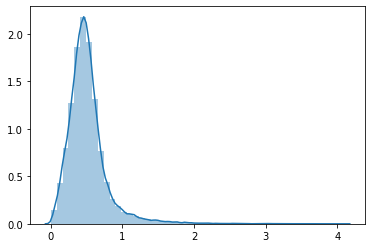

In [9]:
model = Myrtle10().to(device)

print(next(enumerate(test_loader)))
for batch_id, (X, y) in enumerate(train_loader):
  if batch_id > 20:
    break
  X, y = X.float().to(device), y.to(device)
  model.readout(X)

_, (X, y) = next(enumerate(train_loader))
X, y = X.float().to(device), y.to(device)


output = model.readout(X).detach().cpu().numpy()
sns.distplot(output.reshape(-1))

np.std(output.reshape(-1))

epoch 0/20, 0s since start


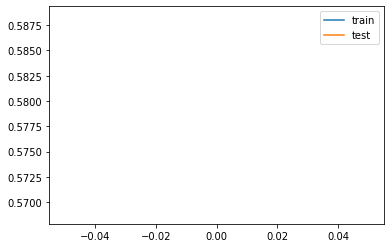

epoch 1/20, 24s since start


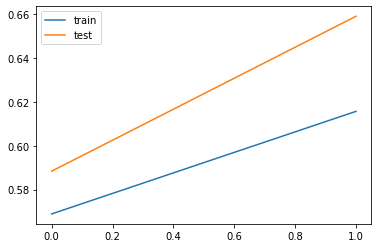

epoch 2/20, 47s since start


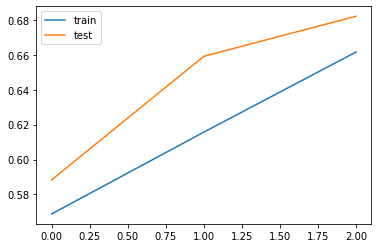

epoch 3/20, 71s since start


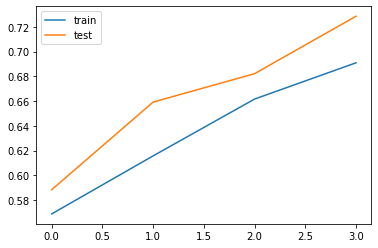

epoch 4/20, 94s since start


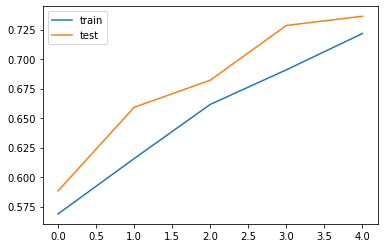

epoch 5/20, 117s since start


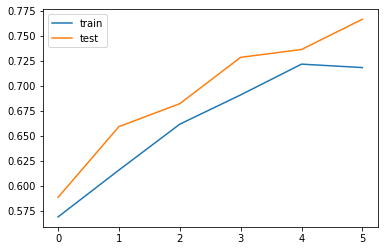

epoch 6/20, 141s since start


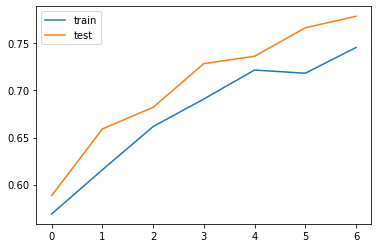

epoch 7/20, 164s since start


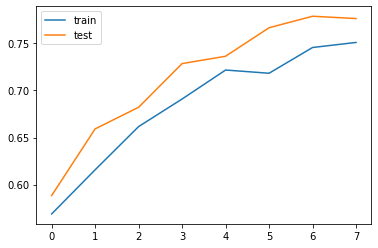

epoch 8/20, 187s since start


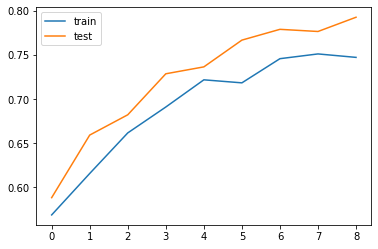

epoch 9/20, 211s since start


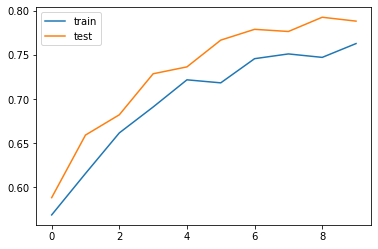

epoch 10/20, 234s since start


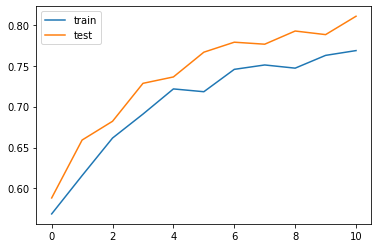

epoch 11/20, 258s since start


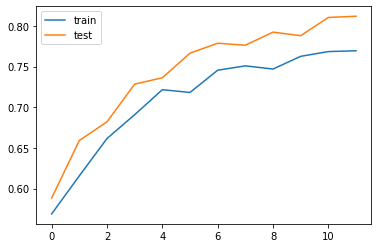

epoch 12/20, 281s since start


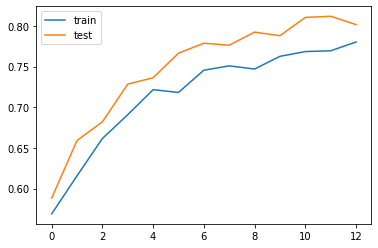

epoch 13/20, 304s since start


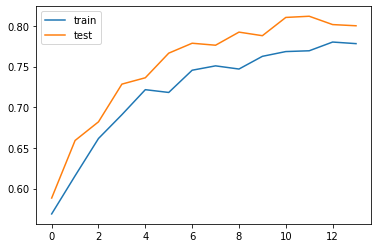

epoch 14/20, 328s since start


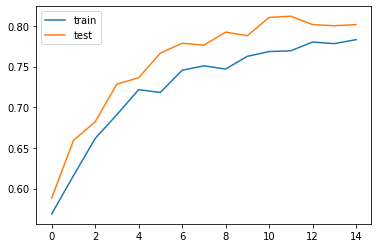

epoch 15/20, 352s since start


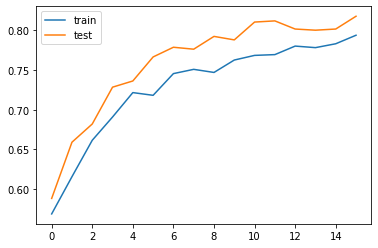

epoch 16/20, 376s since start


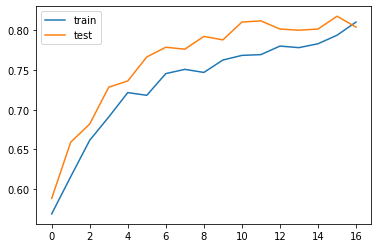

epoch 17/20, 400s since start


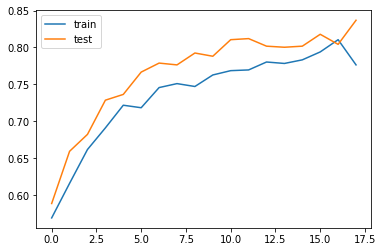

epoch 18/20, 424s since start


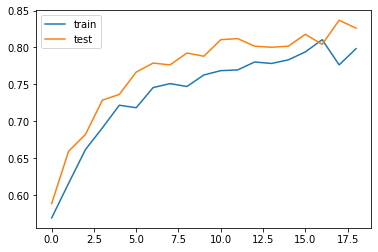

epoch 19/20, 447s since start


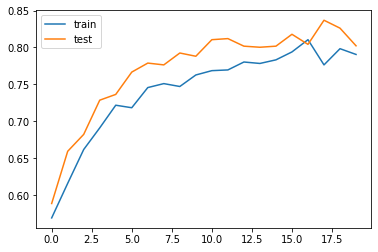

training took 471s
test_accuracy 0.822


In [10]:
model = Myrtle10(num_filters=32).to(device)

learning_rate = 0.05

estimator = SgdEstimator(model, nn.CrossEntropyLoss(), learning_rate)
training  = ClassifierTraining(estimator, device)

training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

epoch 0/20, 0s since start


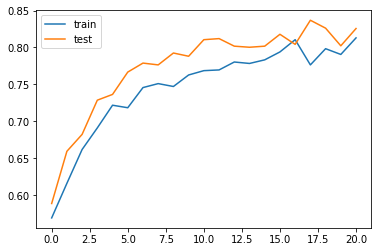

epoch 1/20, 24s since start


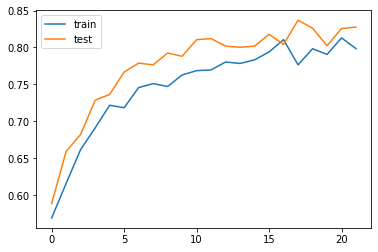

epoch 2/20, 48s since start


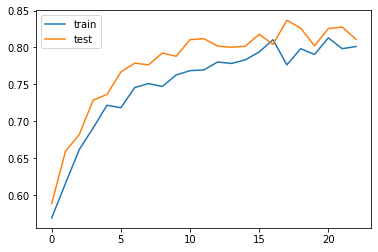

epoch 3/20, 71s since start


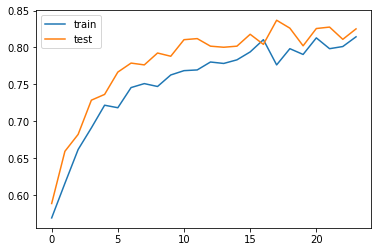

epoch 4/20, 95s since start


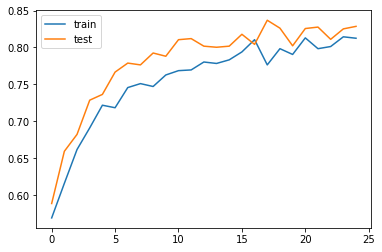

epoch 5/20, 118s since start


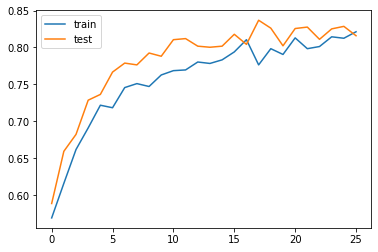

epoch 6/20, 142s since start


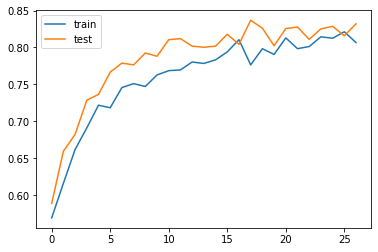

epoch 7/20, 165s since start


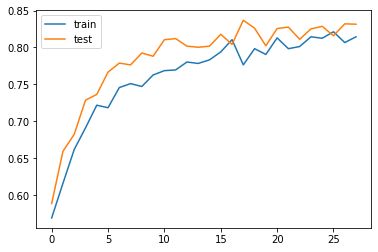

epoch 8/20, 189s since start


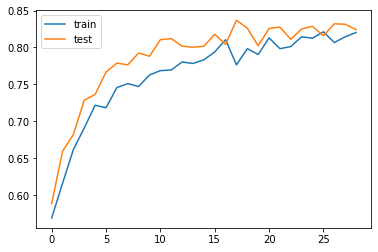

epoch 9/20, 212s since start


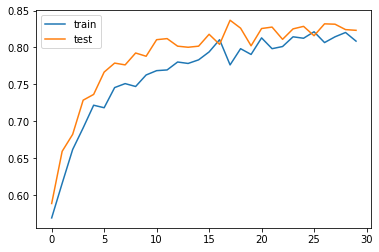

epoch 10/20, 236s since start


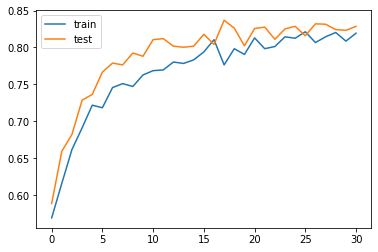

epoch 11/20, 259s since start


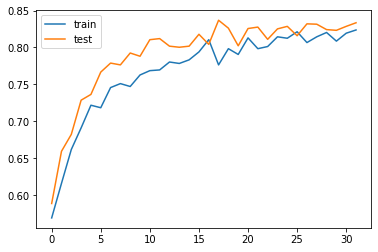

epoch 12/20, 282s since start


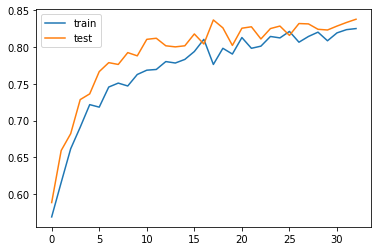

epoch 13/20, 306s since start


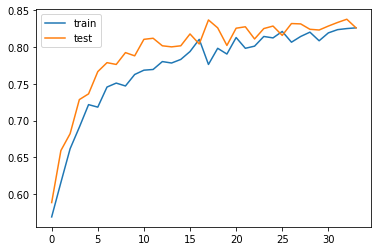

epoch 14/20, 329s since start


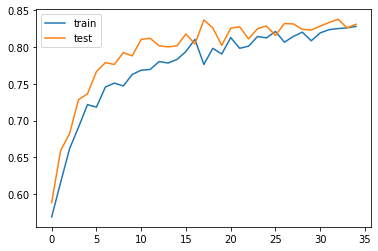

epoch 15/20, 353s since start


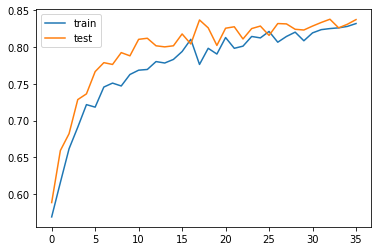

epoch 16/20, 377s since start


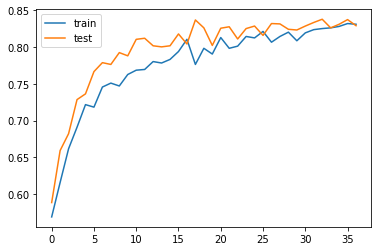

epoch 17/20, 400s since start


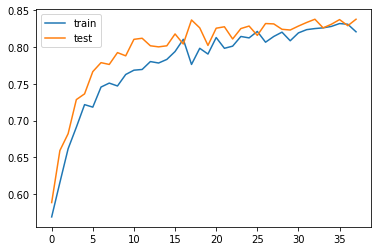

epoch 18/20, 424s since start


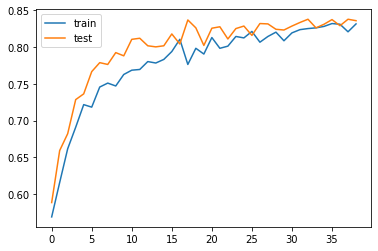

epoch 19/20, 448s since start


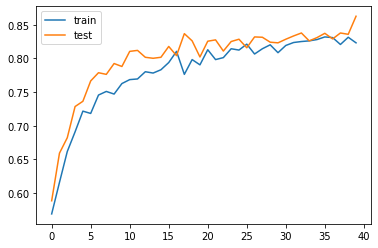

training took 472s
test_accuracy 0.842


In [13]:
training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

epoch 0/20, 0s since start


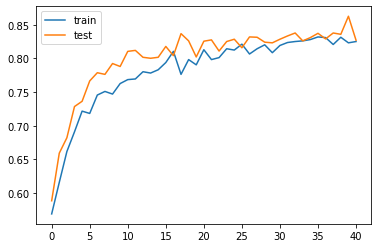

epoch 1/20, 24s since start


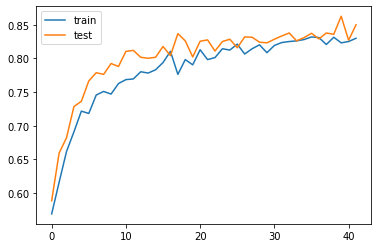

epoch 2/20, 47s since start


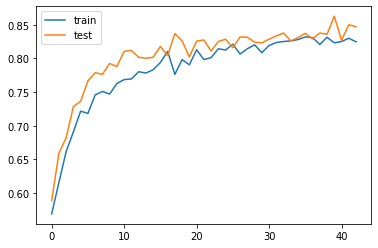

epoch 3/20, 70s since start


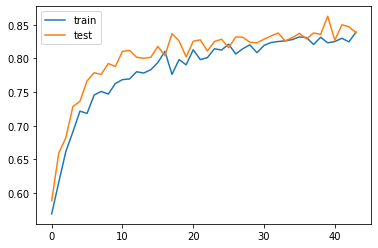

epoch 4/20, 93s since start


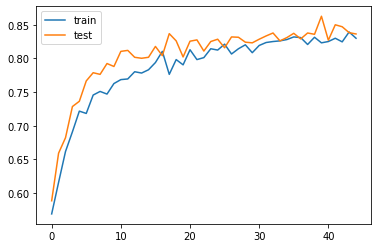

epoch 5/20, 116s since start


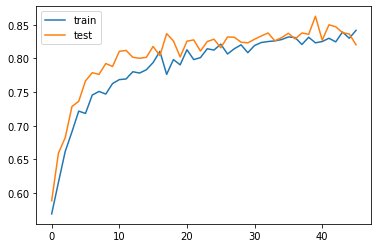

epoch 6/20, 140s since start


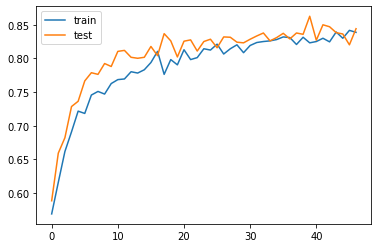

epoch 7/20, 164s since start


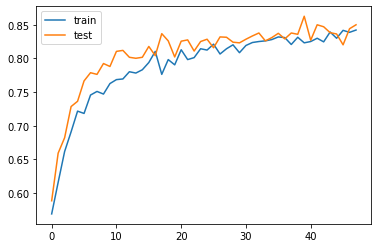

epoch 8/20, 188s since start


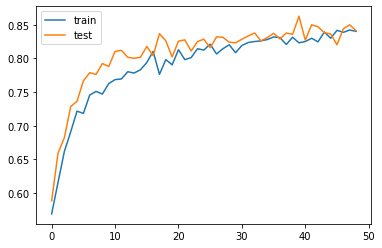

epoch 9/20, 212s since start


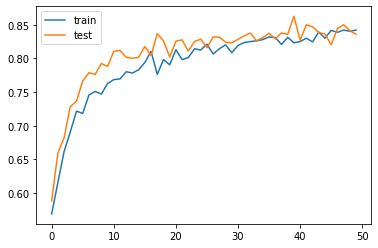

epoch 10/20, 235s since start


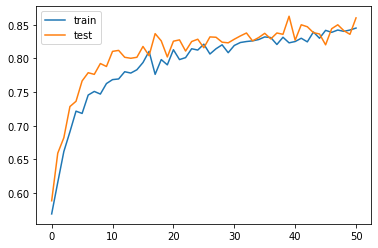

epoch 11/20, 258s since start


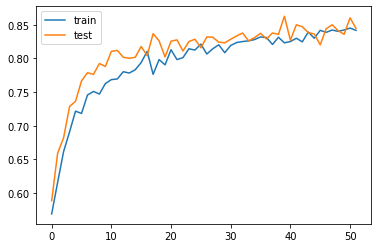

epoch 12/20, 282s since start


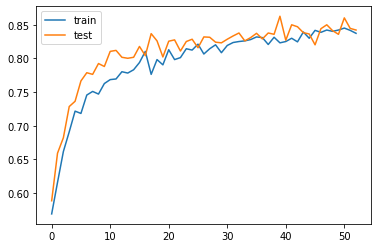

epoch 13/20, 305s since start


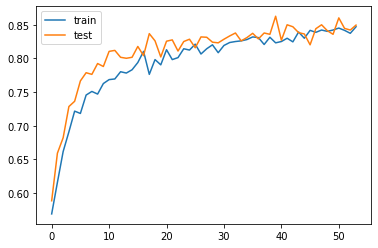

epoch 14/20, 329s since start


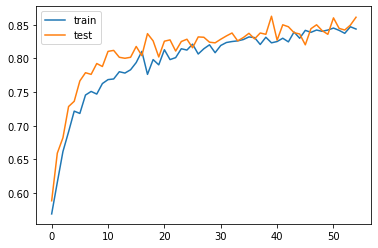

epoch 15/20, 352s since start


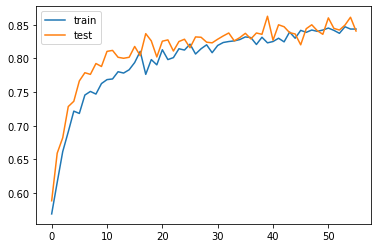

epoch 16/20, 375s since start


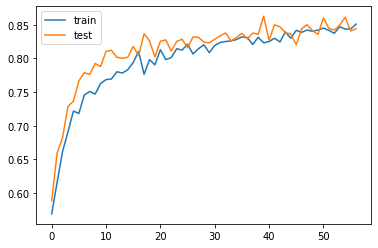

epoch 17/20, 399s since start


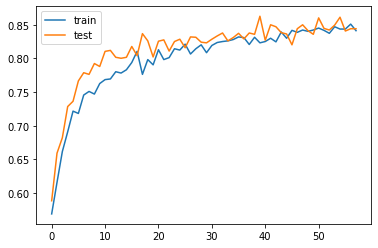

epoch 18/20, 422s since start


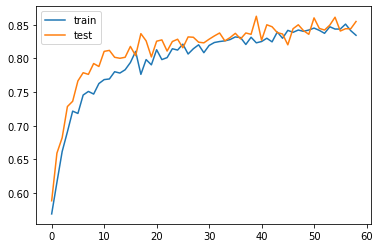

epoch 19/20, 445s since start


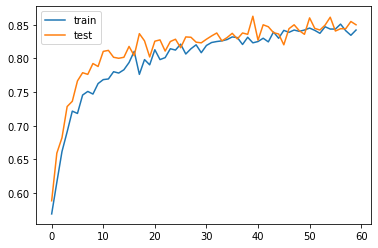

training took 468s
test_accuracy 0.844


In [15]:
training.train(train_loader, test_loader, num_epochs=20, learning_rate=learning_rate)

In [11]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.8177412974683544

In [14]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.8410799050632911

In [16]:
ClassifierTraining(estimator, device).get_accuracy(test_loader)

0.844442246835443

In [0]:
"""
TODO experiments:
1. ZCA ✔️
2. random features with/without batchnorm
"""
pass